# Rings segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam

import matplotlib.pyplot as plt

# Magic used by the notebook to show figures inline
%matplotlib inline
# matplotlib default values
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading packages
%load_ext autoreload
%autoreload 2

# local package
from dlia_tools.u_net import u_net
from dlia_tools.keras_image2image import DeadLeavesWithSegmGenerator
from dlia_tools.keras_custom_loss import jaccard2_loss
from dlia_tools.random_image_generator import AdditiveGaussianNoise
from dlia_tools.random_image_generator import ROG_disks, ROG_rings, RandomPosGenUniform, RandomIntGenUniform

Using TensorFlow backend.


# Using a data generator

In [2]:
# ****  input data generator
img_rows, img_cols = 32, 32
img_channels = 1
gauss_n_std = 40
nb_obj_l = 1
nb_obj_h = 4
r1_disk_l = 2
r1_disk_h = 4
r1_ring_l = 4
r1_ring_h = 8
grey_l = 20
grey_h = 200
norm = 255  # normalization constant

# List of random objects that will be used to build the image
l_rog = [
    ROG_rings(
        RandomIntGenUniform(nb_obj_l, nb_obj_h),  # number of rings per image
        RandomPosGenUniform(img_rows, img_cols),  # position
        RandomIntGenUniform(r1_ring_l, r1_ring_h),  # range of values for ring outer radius
        RandomIntGenUniform(grey_l, grey_h),  # grey level value
        gt=1,  # should this object be included in the ground-truth
        rad_ratio=0.5),  # ratio between inner and outer radius
]

noise = AdditiveGaussianNoise(gauss_n_std)
datagen = DeadLeavesWithSegmGenerator(
    img_rows,
    img_cols,
    l_rog,  # list of random object generators
    noise,
    background_val=0,
    norm=norm  # normalization constant
    )


In [4]:
nb_train_samples = 10000
nb_val_samples = 1000
(X_train, Y_train) = next(datagen.flow(batch_size=nb_train_samples))
(X_val, Y_val) = next(datagen.flow(batch_size=nb_val_samples))

Text(0.5, 1.0, 'Segm')

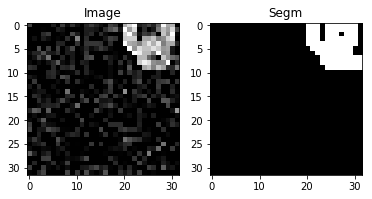

In [5]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(X_train[index, :, :, 0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(Y_train[index, :, :, 0])
plt.title("Segm")

In [6]:
# architecture params
nb_filters_0 = 8
sigma_noise = 0.01

# ****  deep learning model
shape = (img_rows, img_cols, img_channels)
model = u_net(shape, nb_filters_0, sigma_noise=sigma_noise)

# ****  train
opt_name = 'sgd'  # choices:adadelta; sgd, rmsprop, adagrad, adam
loss_func = jaccard2_loss  # mse, mae, binary_crossentropy, jaccard2_loss
if opt_name == "sgd":
    opt = SGD(lr=0.1)
elif opt_name == "rmsprop":
    opt = RMSprop()
elif opt_name == "adagrad":
    opt = Adagrad()
elif opt_name == "adadelta":
    opt = Adadelta()
elif opt_name == "adam":
    opt = Adam(lr=1e-5)
else:
    raise NameError("Wrong optimizer name")
model.compile(loss=loss_func, optimizer=opt)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 32, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 32, 32, 8)    584         conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 8)    0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [7]:
# fit params
batch_size = 128

nb_epoch = 20

verbose = 1
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(X_val, Y_val),
                    shuffle=True,
                    verbose=verbose)

Train on 10000 samples, validate on 1000 samples
Epoch 1/20
10000/10000 [==============================] - 5s 494us/step - loss: 0.8156 - val_loss: 0.8108
Epoch 2/20
10000/10000 [==============================] - 2s 194us/step - loss: 0.7393 - val_loss: 0.5304
Epoch 3/20
10000/10000 [==============================] - 2s 193us/step - loss: 0.4120 - val_loss: 0.3473
Epoch 4/20
10000/10000 [==============================] - 2s 202us/step - loss: 0.2975 - val_loss: 0.3172
Epoch 5/20
10000/10000 [==============================] - 2s 208us/step - loss: 0.2412 - val_loss: 0.2241
Epoch 6/20
10000/10000 [==============================] - 2s 203us/step - loss: 0.2199 - val_loss: 0.2083
Epoch 7/20
10000/10000 [==============================] - 2s 199us/step - loss: 0.2073 - val_loss: 0.2412
Epoch 8/20
10000/10000 [==============================] - 2s 202us/step - loss: 0.2019 - val_loss: 0.2017
Epoch 9/20
10000/10000 [==============================] - 2s 205us/step - loss: 0.1918 - val_loss: 0.20

In [8]:
# **** #####################################"
print("Best validation loss: %.5f" % (np.min(history.history['val_loss'])))
print("at: %d" % np.argmin(history.history['val_loss']))

Best validation loss: 0.16521
at: 18


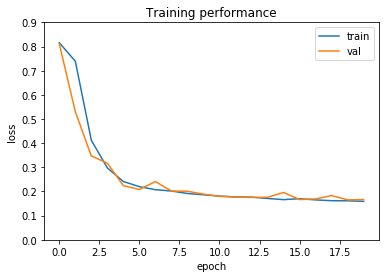

In [9]:
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim(0.0, 0.9)
plt.show()

# Test

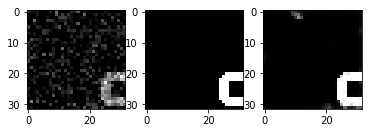

In [10]:
(X_test, Y_test) = next(datagen.flow(batch_size=1))
Y_pred = model.predict(X_test)
plt.subplot(1, 3, 1)
plt.imshow(X_test[0,:,:,0])
plt.subplot(1, 3, 2)
plt.imshow(Y_test[0,:,:,0])
plt.subplot(1, 3, 3)
plt.imshow(Y_pred[0,:,:,0])

In [11]:
# Quantitative evaluation
from dlia_tools.eval import jaccard
(X_test, Y_test) = next(datagen.flow(batch_size=100))
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)

print("Jaccard on training set:", jaccard(Y_train, Y_train_pred))
print("Jaccard on validation set:", jaccard(Y_val, Y_val_pred))
print("Jaccard on test set:", jaccard(Y_test, Y_test_pred))

Jaccard on training set: 0.725698
Jaccard on validation set: 0.71624166
Jaccard on test set: 0.7275265


# Rings occluded by disks

We are now dealing with a more complex problem: our rings can be occluded by random disks. 

Try to learn nevertheless to segment them. 

1) Is learning as easy as before?

2) Does the network correctly predicts non-occluded ring pixels?

3) Does it manage to segment occluded pixels?

In [12]:
# ****  input data generator
img_rows, img_cols = 32, 32
img_channels = 1
gauss_n_std = 40
nb_obj_l = 1
nb_obj_h = 4
r1_disk_l = 2
r1_disk_h = 4
r1_ring_l = 4
r1_ring_h = 8
grey_l = 20
grey_h = 200
norm = 255  # normalization constant

# List of random objects that will be used to build the image
l_rog = [
    ROG_rings(
        RandomIntGenUniform(nb_obj_l, nb_obj_h),
        RandomPosGenUniform(img_rows, img_cols),
        RandomIntGenUniform(r1_ring_l, r1_ring_h),
        RandomIntGenUniform(grey_l, grey_h),
        gt=1,
        rad_ratio=0.5),
    ROG_disks(
        RandomIntGenUniform(3 * nb_obj_l, 3 * nb_obj_h),
        RandomPosGenUniform(img_rows, img_cols),
        RandomIntGenUniform(r1_ring_l, r1_ring_h),
        RandomIntGenUniform(grey_l, grey_h),
        gt=0),
]

noise = AdditiveGaussianNoise(gauss_n_std)
datagen = DeadLeavesWithSegmGenerator(
    img_rows,
    img_cols,
    l_rog,
    noise,
    background_val=0,
    shuffle=False,
    norm=norm)
datagen_val = DeadLeavesWithSegmGenerator(
    img_rows,
    img_cols,
    l_rog,
    noise,
    background_val=0,
    shuffle=False,
    norm=norm)

In [13]:
print("Generating images...")
(X_train, Y_train) = next(datagen.flow(batch_size=nb_train_samples))
(X_val0, Y_val0) = next(datagen_val.flow(batch_size=nb_val_samples))
print("Generation finished")

Generating images...
Generation finished


Text(0.5, 1.0, 'Segm')

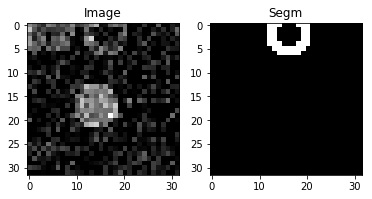

In [14]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(X_train[index, :, :, 0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(Y_train[index, :, :, 0])
plt.title("Segm")

# Model specificity

Teach a model to segment a given type of rings - for example based on the ratio between outer and inner ring. How well will it segment other types of rings? How can this be improved?